In [123]:
import numpy as np
h = 6.62607015 * (10 ** (-34)) # J/s
c = 299792458 # m/s

alpha = 10                                 # detection sigma threshold
num = 0.131557                             # numerical factor
d_E_ly = 1470                              # distance to emitting star (4.246ly to Proxima Centauri) [ly]
d_E = d_E_ly * (9.461 * 10 ** 15)          # distance to emitting star [m]
d_T = 2.4                                  # emitting telescope diameter [m]
A_apf = np.pi * (1.2 ** 2)                 # area of recieving telescope [m**2]
wl_l = 5 * (10 ** (-7))                    # laser wavelength [m]
Lo = 3.828 * (10 ** 26)                    # luminosisty of host star [W]
d_wl = 0.017 * (10 ** (-10))  * 3.6        # Wavelength scale bin size near laser wavelength [m/pixel] (0.017 at 5000 A to 0.021 A/pixel at 6400 A for APF scale)
epsilon = 0.05                             # efficiency of receiving telescope (APF is 5%)
N_obs = 2                                  # number of spectra stacked together
dt = 727.68 * N_obs                        # observing time [s] -- median over all spectra in our dataset
d_wl_star = 5 * (10 ** (-7))               # wavelength region span [m] (4000A to 9000A)



### Formulation using spectrum SNR 


In [118]:
alpha = 10 
N_obs = 1
dt = 600 
numer = np.pi * h * c * (wl_l ** 3) * Lo * d_wl
denom = epsilon * dt * A_apf * d_wl_star
prefactor = (alpha * num * d_E) / d_T ** 2
L_em = prefactor * (numer/denom) ** (1/2) 
#L_em = alpha * num * d_E * (wl_l ** (3/2)) * ((Lo * d_wl) ** (1/2)) * (d_T ** (-2)) * ((epsilon * dt * A_apf * d_wl_star) ** (-1/2))  # [W]
L_em /= (10 ** 6) # MWs
print('distance: ' + str(d_E_ly) + ' ly')
print('required emitting luminosity: ' + str(np.round(L_em, 4)) + ' MW')
print('required emitting luminosity, corrected by sqrt(2): ' + str(np.round(L_em * np.sqrt(2), 4)) + ' MW')

distance: 78.47 ly
required emitting luminosity: 0.2783 MW
required emitting luminosity, corrected by sqrt(2): 0.3935 MW


In [119]:
# Should give exact same result as lipman

print('Lipmans expression [MW]: ' + str((1.86 * d_E / (d_T**2)) * ((Lo * d_wl * h * c * np.pi * (wl_l**3))/(d_wl_star * A_apf * dt * epsilon)) ** (1/2) / 1e6)) #* np.sqrt(10)
print('"de-correct" for nm vs A in d_wl [MW]: ' + str(((1.86 * d_E / (d_T**2)) * ((Lo * d_wl * h * c * np.pi * (wl_l**3))/(d_wl_star * A_apf * dt * epsilon)) ** (1/2)) * np.sqrt(10) / 1e6))
#
# the second gives the reported value in the paper, but the first is the same as what I get except for our factor of 

Lipmans expression [MW]: 0.3934226221513593
"de-correct" for nm vs A in d_wl [MW]: 1.2441115690341091


In [88]:
def calc_alpha(L_em, d_E):
    numer = np.pi * h * c * (wl_l ** 3) * Lo * d_wl
    denom = epsilon * dt * A_apf * d_wl_star
    prefactor =  (L_em * (d_T ** 2)) / (num * d_E)
    alpha = prefactor * ((denom/numer) ** (1/2))
    return alpha

Lipman_alpha = calc_alpha(5.2128  * 10**6, 1470 * (9.461 * 10 ** 15))
# Tellis 2015
Tellis_alpha1 = calc_alpha(90 , 100 * (9.461 * 10 ** 15))
Tellis_alpha2 = calc_alpha(1000 , 1000 * (9.461 * 10 ** 15))
print(Lipman_alpha) # should be 10, by design
print(Tellis_alpha1)
print(Tellis_alpha2)

14.142039064542935
0.0035892260747372434
0.003988028971930271


In [89]:
# Tellis 2017: They chacnge their exposure time such that they keep a constant SNR, and thus distance does not effect their sensetivities. 
# So, the alpha value that would be required to reach their sensetivity varies depending on distance.
# Their sensetivities do depend on wavelength, so for each distance there is an upper and lower alpha value required to 
# reach their upper and lower sensetivities. 

low_laser_lum = 3 * (10 ** 3) # 3 kW
high_laser_lum = 13 * (10 ** 6) # 13 MW

distances = [10, 100, 1000]
for d_E_ly in distances:
    d_E = d_E_ly * (9.461 * 10 ** 15)
    low_alpha =  calc_alpha(low_laser_lum, d_E)
    high_alpha =  calc_alpha(high_laser_lum, d_E)
    
    print()
    print(str(d_E_ly) + ' ly: ')
    print('min alpha (3 kW laser): ' + str(np.round(low_alpha,4)))
    print('max alpha (13 MW laser): ' + str(np.round(high_alpha,4)))
    
print()
print('Median distance to star in APF target set (78.47 ly):')
d_E_ly = 78.47
d_E = d_E_ly * (9.461 * 10 ** 15)
low_alpha =  calc_alpha(low_laser_lum, d_E)
high_alpha =  calc_alpha(high_laser_lum, d_E)
print('min alpha (3 kW laser): ' + str(np.round(low_alpha,4)))
print('max alpha (13 MW laser): ' + str(np.round(high_alpha,4)))

    


10 ly: 
min alpha (3 kW laser): 1.1964
max alpha (13 MW laser): 5184.4377

100 ly: 
min alpha (3 kW laser): 0.1196
max alpha (13 MW laser): 518.4438

1000 ly: 
min alpha (3 kW laser): 0.012
max alpha (13 MW laser): 51.8444

Median distance to star in APF target set (78.47 ly):
min alpha (3 kW laser): 0.1525
max alpha (13 MW laser): 660.6904


### Formulation using spectrum AMD

In [124]:
def calc_Lem(alpha, AMD, d_E):
    prefactor = ((1.22**2) * np.pi * h * c) / 4
    numer = alpha * AMD * wl_l * d_E**2
    denom = epsilon * dt * A_apf * d_T**2
    L_em = prefactor * (numer/denom)
    return L_em

In [125]:
def calc_alpha(L_em, d_E):
    numer = L_em * epsilon * dt * A_apf * d_T**2
    denom = AMD * wl_l * d_E**2 * prefactor
    alpha = numer/denom
    return alpha

In [127]:
# example calculation
median_AMD = 414.78 # median residual AMD converted to photon counts for out target set
alpha_example = 6
d_E_ly = 78.47 # median distance to stars in our target set
d_E = d_E_ly * (9.461 * 10 ** 15)
example_Lem = calc_Lem(alpha_example, median_AMD, d_E)
print('EXAMPLE (Using median values):')
print('Choose alpha = ' + str(alpha_example) + ', for a star with the median distance (78.47ly) and median AMD in our target set, detection requires:')
print('Laser luminosity > ' + str(np.round(example_Lem/(10 ** 6),3)) + ' MW')
#print('                 > ' + str(np.round(example_Lem/(10 ** 3),3)) + ' kW')
#print('                 > ' + str(np.round(example_Lem/(10 ** 6),3)) + ' MW')
print()

# Comparison to Lipman
d_E_ly =  1470 # distance to Boyajian's Star
d_E = d_E_ly * (9.461 * 10 ** 15)
KIC8462852_AMD = 110.65 # Boyajian's Star 
Lipman_Lem = calc_Lem(alpha_example, KIC8462852_AMD, d_E)
print('LIPMAN COMPARISON (Using Boyajian\'s Star. They report limit of 7.37 MW):')
print('Choose alpha = ' + str(alpha_example) + ', with the AMD of Boyajian\'s Star at the distance of Boyajian\'s Star detection requires:')
print('Laser luminosity > ' + str(np.round(Lipman_Lem/(10 ** 6),3)) + ' MW')
#print('                 > ' + str(np.round(Lipman_Lem/(10 ** 3),3)) + ' kW')
#print('                 > ' + str(np.round(Lipman_Lem/(10 ** 6),3)) + ' MW')
print()

# Comparison to Tellis 2015
d_E_ly =  100 # distance reported 
d_E = d_E_ly * (9.461 * 10 ** 15)
T2015_Lem = calc_Lem(alpha_example, median_AMD, d_E)
print('TELLIS 2015 COMPARISON (They report limit of 90 W at 100 ly):')
print('Choose alpha = ' + str(alpha_example) + ', for a star with the median AMD in our target set, detection at 100 ly requires:')
print('Laser luminosity > ' + str(np.round(T2015_Lem/(10 ** 6),3)) + ' MW')
#print('                 > ' + str(np.round(T2015_Lem/(10 ** 3),3)) + ' kW')
#print('                 > ' + str(np.round(T2015_Lem/(10 ** 6),3)) + ' MW')
d_E_ly =  1000 # distance reported 
d_E = d_E_ly * (9.461 * 10 ** 15)
T2015_Lem = calc_Lem(alpha_example, median_AMD, d_E)
print('TELLIS 2015 COMPARISON (They ALSO report limit of 1 kW at 1000 ly):')
print('Choose alpha = ' + str(alpha_example) + ', for a star with the median AMD in our target set, detection at 1000 ly requires:')
print('Laser luminosity > ' + str(np.round(T2015_Lem/(10 ** 6),3)) + ' MW')
#print('                 > ' + str(np.round(T2015_Lem/(10 ** 3),3)) + ' kW')
#print('                 > ' + str(np.round(T2015_Lem/(10 ** 6),3)) + ' MW')
print()

# Comparison to Tellis 2017
d_E_ly =  78.47 # median distance to stars in our target set
d_E = d_E_ly * (9.461 * 10 ** 15)
T2017_Lem = calc_Lem(alpha_example, median_AMD, d_E)
print('TELLIS 2017 COMPARISON (They report limit of between 3 kw and 13 MW across the spectrum regardless of distance):')
print('Choose alpha = ' + str(alpha_example) + ', for a star with the median AMD in our target set, detection at median distance requires:')
print('Laser luminosity > ' + str(np.round(T2017_Lem/(10 ** 6),3)) + ' MW')
#print('                 > ' + str(np.round(T2017_Lem/(10 ** 3),3)) + ' kW')
#print('                 > ' + str(np.round(T2017_Lem/(10 ** 6),3)) + ' MW')

EXAMPLE (Using median values):
Choose alpha = 6, for a star with the median distance (78.47ly) and median AMD in our target set, detection requires:
Laser luminosity > 0.084 MW

LIPMAN COMPARISON (Using Boyajian's Star. They report limit of 7.37 MW):
Choose alpha = 6, with the AMD of Boyajian's Star at the distance of Boyajian's Star detection requires:
Laser luminosity > 7.863 MW

TELLIS 2015 COMPARISON (They report limit of 90 W at 100 ly):
Choose alpha = 6, for a star with the median AMD in our target set, detection at 100 ly requires:
Laser luminosity > 0.136 MW
TELLIS 2015 COMPARISON (They ALSO report limit of 1 kW at 1000 ly):
Choose alpha = 6, for a star with the median AMD in our target set, detection at 1000 ly requires:
Laser luminosity > 13.64 MW

TELLIS 2017 COMPARISON (They report limit of between 3 kw and 13 MW across the spectrum regardless of distance):
Choose alpha = 6, for a star with the median AMD in our target set, detection at median distance requires:
Laser lumin

In [128]:
# effect of going to residuals

d_E_ly = 78.47 # median distance to stars in our target set in ly
d_E = d_E_ly * (9.461 * 10 ** 15) # in m
median_beta = (4 * dt * N_obs * A_apf * d_T**2) / (1.22**2 * np.pi * h * c * wl_l * d_E**2)
print(median_beta)

representative_feature_depth = 10000 * 0.5 # varies from 0.1 to 0.9 ish
luministy_effect = representative_feature_depth/median_beta
print(str(luministy_effect) + ' W')
print(str(luministy_effect  / 10**6) + ' MW')

print('descrease in sensetivity in an representative absoprtion feature: ' + str(luministy_effect/example_Lem * 100) + ' %')

1.1852162809423143
4218.639315370116 W
0.004218639315370115 MW
descrease in sensetivity in an representative absoprtion feature: 5.022742980214412 %


In [130]:
import matplotlib.pyplot as plt

0.0053266331658291454
124.62311557788944


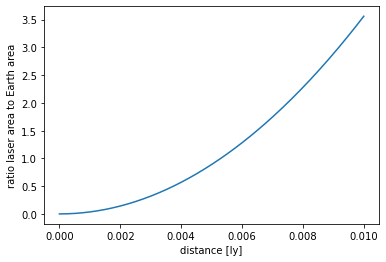

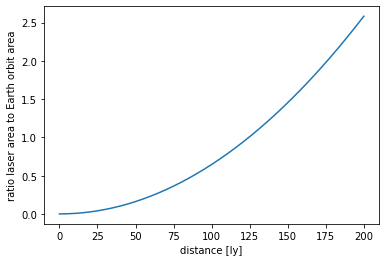

In [146]:
# Fractional solid angle subtended by a laser emitted from "APF"
frac_A = (1.22 * wl_l)**2/(4 * d_T)**2
frac_A 

# how does this compare to area of earth, or earth's orbit, at a given distance?
R_Earth = 6371000 #m
A_Earth = np.pi * R_Earth**2
R_orbit = 1.496 * 10**11 #m (1 AU)
A_orbit = np.pi * R_orbit**2
d_ly = np.linspace(0,0.01,200) # ly
d = d_ly * (9.461 * 10 ** 15) # m
ratio_Earth = (np.pi/A_Earth) * ((1.22*d*wl_l)/(2*d_T))**2
plt.figure()
plt.plot(d_ly,ratio_Earth)
plt.xlabel('distance [ly]')
plt.ylabel('ratio laser area to Earth area')
print(d_ly[np.where(ratio_Earth > 1)[0][0]])

d_ly = np.linspace(0,200,200) # ly
d = d_ly * (9.461 * 10 ** 15) # m
ratio_orbit = (np.pi/A_orbit) * ((1.22*d*wl_l)/(2*d_T))**2
plt.figure()
plt.plot(d_ly,ratio_orbit)
plt.xlabel('distance [ly]')
plt.ylabel('ratio laser area to Earth orbit area')
print(d_ly[np.where(ratio_orbit > 1)[0][0]])